In [1]:
import numpy as np
import pandas as pd

# Visualizastion
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set_palette(sns.color_palette("deep", 10))
sns.set_style("whitegrid")

# Sklearn
from sklearn.metrics import classification_report
from sklearn.base import clone
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier

# Hyperparameter Optimization
import optuna

In [3]:
df_train = pd.read_csv("train.csv", index_col='id')

In [4]:
df_train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


# Impute Missing Values

<Axes: >

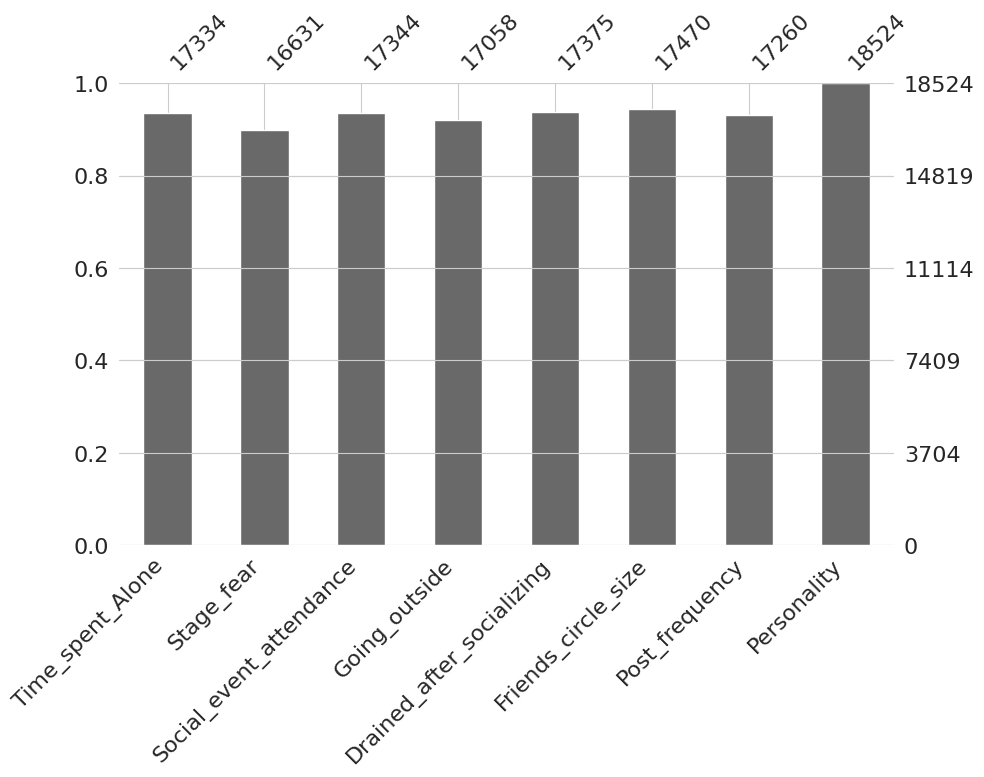

In [6]:
msno.bar(df_train, figsize=(10, 6))

We'll fill the missing values of ```Stage_fear``` and ```Drained_from_socializing``` features using the ```mode```.

For the rest of the features we'll use the ```mean```.

In [8]:
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('Personality')

# for col in categorical_columns:
#     mode = df_train[col].mode()[0]
#     df_train[col].fillna(mode, inplace=True)
#     if col in df_test.columns:
#         df_test[col].fillna(mode, inplace=True)

mode_imputer = SimpleImputer(strategy='most_frequent')
df_train[categorical_columns] = mode_imputer.fit_transform(df_train[categorical_columns])

In [9]:
numeric_columns = df_train.select_dtypes(include=["float64"]).columns.tolist()

# for col in numeric_columns:
#     mean = df_train[col].mean()
#     df_train[col].fillna(mean, inplace=True)
#     if col in df_test.columns:
#         df_test[col].fillna(mean, inplace=True)

mean_imputer = SimpleImputer(strategy='mean')
df_train[numeric_columns] = mean_imputer.fit_transform(df_train[numeric_columns])

for col in numeric_columns:
    df_train[col] = df_train[col].astype(int)

# Visualization

## Personality

We would first like to check if there is imbalance in our dataset:

<Axes: xlabel='Personality', ylabel='count'>

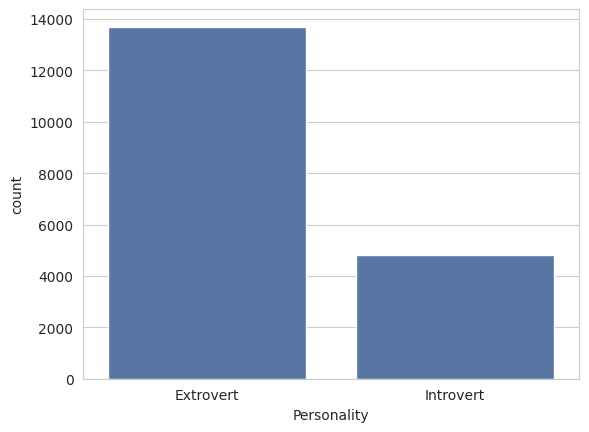

In [10]:
sns.countplot(df_train, x="Personality")

We can see that indeed the data is very imbalanced and there are way more extrovert examples than there are of introvert, and we need to adress this when fitting a model.

## Stage_Fear

<Axes: xlabel='Personality', ylabel='count'>

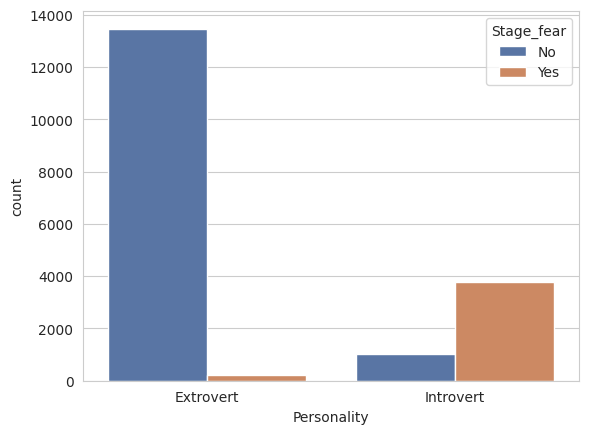

In [11]:
sns.countplot(df_train, x="Personality", hue="Stage_fear")

In [12]:
df_train[df_train['Stage_fear'] == 'Yes']['Personality'].value_counts()

Personality
Introvert    3786
Extrovert     236
Name: count, dtype: int64

## Drained_after_socializing

<Axes: xlabel='Personality', ylabel='count'>

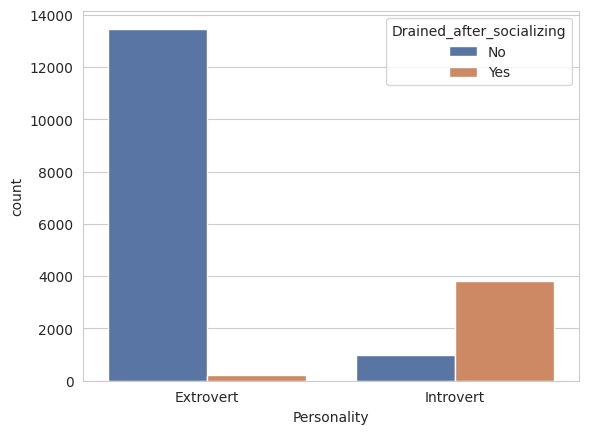

In [13]:
sns.countplot(df_train, x="Personality", hue="Drained_after_socializing")

In [14]:
df_train[df_train['Drained_after_socializing'] == 'Yes']['Personality'].value_counts()

Personality
Introvert    3826
Extrovert     236
Name: count, dtype: int64

## Conclusion

We can see that both "Stage Fear" and "Drained After Socializing" match our logic about a person's personality: introverts are more likely to have stage fear and be drained after socializing, whereas it's the opposite for extroverts.

## Time_spent_Alone

<Axes: xlabel='Personality', ylabel='count'>

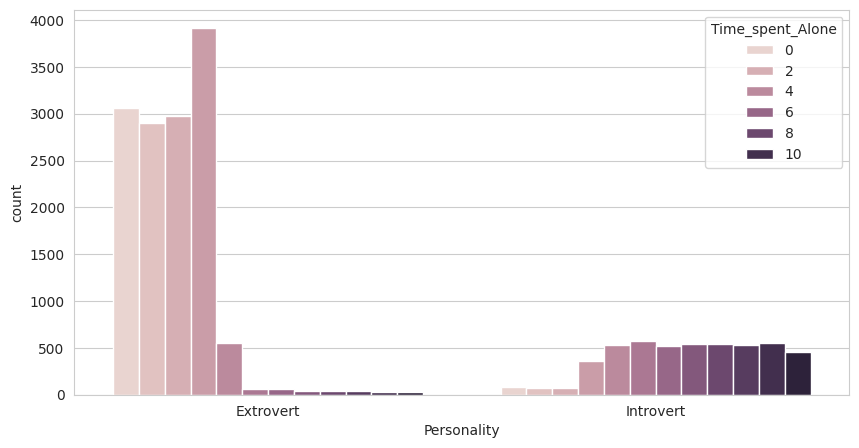

In [15]:
plt.figure(figsize=(10, 5))
sns.countplot(df_train, x="Personality", hue="Time_spent_Alone")

We can see that introverts are more likely to spend more time alone than extroverts.

## Social_event_attendance

<Axes: xlabel='Personality', ylabel='count'>

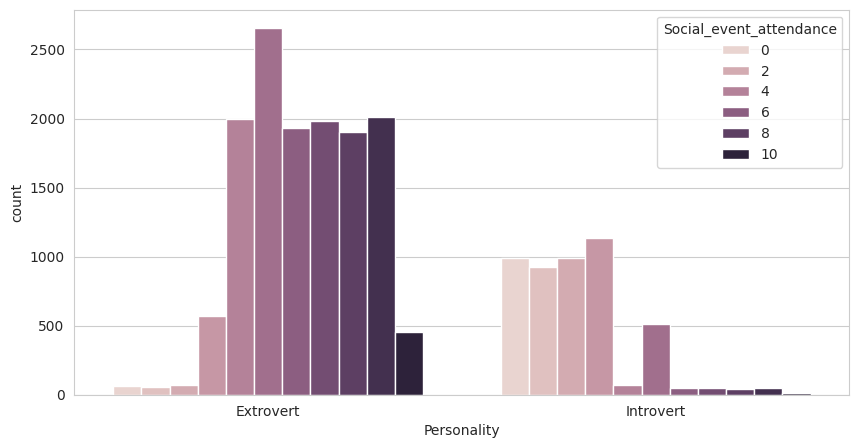

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(df_train, x="Personality", hue="Social_event_attendance")

We can see that most of the introverts rated their social event attendance a low number whereas the extroverts rated it higher.

## Going_outside

<Axes: xlabel='Personality', ylabel='count'>

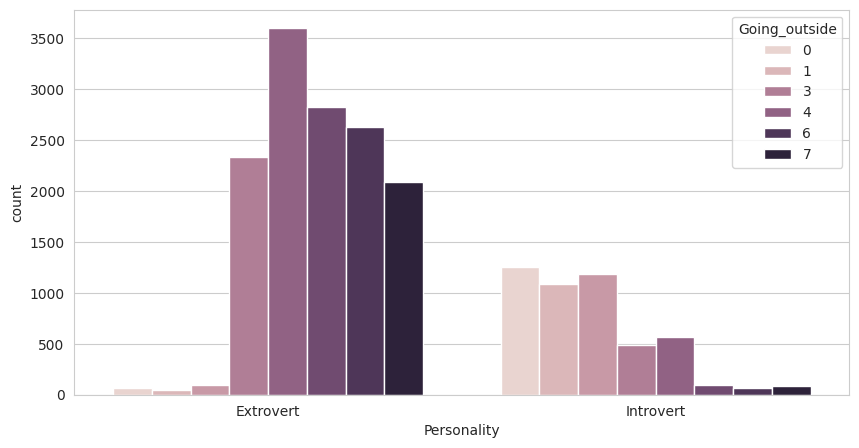

In [17]:
plt.figure(figsize=(10, 5))
sns.countplot(df_train, x="Personality", hue="Going_outside")

We can see that extroverts are more prawn to go outside than introverts since most of the extroverts rated going outside a number higher than 3 whereas introverts mostly rated it lower than 4.

## Friends_circle_size

<Axes: xlabel='Personality', ylabel='count'>

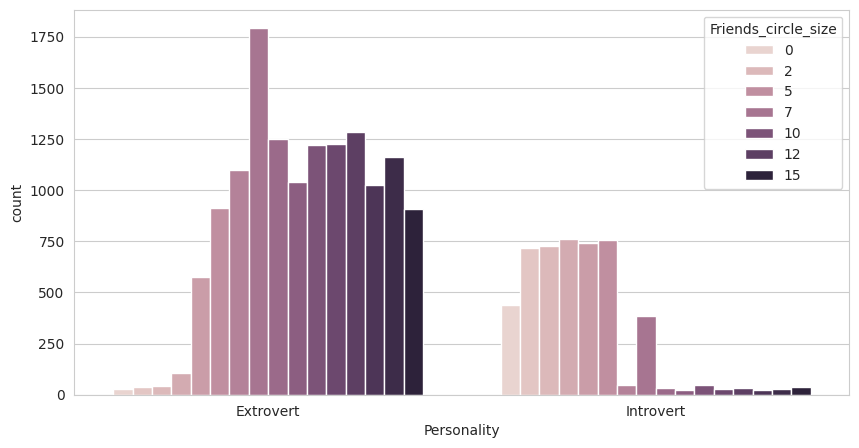

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(df_train, x="Personality", hue="Friends_circle_size")

We can conclude that an introvert is more likely to have a smaller group of friends than an extrovert.

## Post_frequency

<Axes: xlabel='Personality', ylabel='count'>

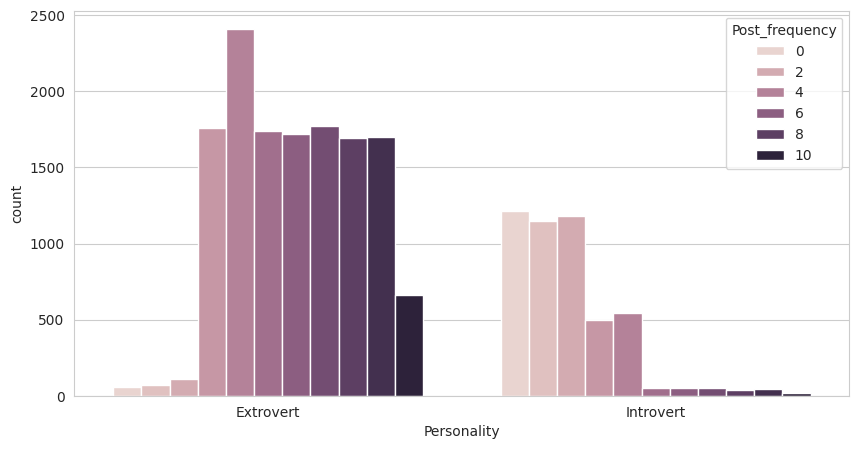

In [19]:
plt.figure(figsize=(10, 5))
sns.countplot(df_train, x="Personality", hue="Post_frequency")

We can conlude that an extrovert will post more on social media than an introvert.

# Preprocess Data

## Stage_fear and Drained_after_socializing

In [20]:
for col in categorical_columns:
    df_train[col] = df_train[col].map({"No": 0, "Yes": 1})

## Target encoding

In [21]:
df_train["Personality"] = df_train["Personality"].map({"Introvert": 1, "Extrovert": 0})

# Train Model

We will consider 8 models and compare each of their performance according to their accuracy:
1. Logistic Regression
2. SVM
3. Random Forest
4. KNN
5. Naive Bayes
6. MLP
7. XGBoost
8. LightGBM

We'll put "class_weight='balanced'" for models that have this property to ensure that the model addresses the imbalance of the data.

In [22]:
X = df_train.drop("Personality", axis=1)
y = df_train["Personality"]

In [23]:
X.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
id,,,,,,,
0,0,0,6,4,0,15,5
1,1,0,7,3,0,10,8
2,6,1,1,0,0,3,0
3,3,0,7,3,0,11,5
4,1,0,4,4,0,13,4


In [23]:
# Define models
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(kernel="rbf", probability=True, class_weight='balanced'))
    ]),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier())
    ]),
    "Naive Bayes": GaussianNB(),
    "MLP (Neural Net)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPClassifier(max_iter=500))
    ]),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(class_weight='balanced', objective='binary')
}

In [24]:
# Perform cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
results = []

for name, model in models.items():
    acc = cross_val_score(model, X, y, cv=skf, scoring="accuracy").mean()
    f1 = cross_val_score(model, X, y, cv=skf, scoring="f1").mean()
    auc = cross_val_score(model, X, y, cv=skf, scoring="roc_auc").mean()

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "F1 Score": round(f1, 3),
        "ROC AUC": round(auc, 3)
    })

[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:

In [26]:
# Display results
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df)

                 Model  Accuracy  F1 Score  ROC AUC
0  Logistic Regression     0.969     0.940    0.958
1            SVM (RBF)     0.969     0.940    0.966
3                  KNN     0.969     0.940    0.960
5     MLP (Neural Net)     0.969     0.940    0.968
6              XGBoost     0.968     0.938    0.965
4          Naive Bayes     0.968     0.939    0.957
7             LightGBM     0.968     0.939    0.967
2        Random Forest     0.963     0.929    0.964


We can see that the best models according to accuracy and f1 score are KNN, XGBoost and LightGBM,
while LightGBM has the best ROC AUC score, and so we'll choose the LightGBM model.

# Hyperparameter Optimization

In [27]:
# Hyperparameter optimization using optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": 42,
        "n_jobs": -1,
        "class_weight":'balanced',
        "objective":'binary' 
    }

    model = LGBMClassifier(**params, verbosity=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean()
    return acc

In [28]:
# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

# Show results
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-27 20:58:02,316] A new study created in memory with name: no-name-04a20242-2f8a-42ae-a937-ebf84c9cea2c
[I 2025-07-27 20:58:03,911] Trial 0 finished with value: 0.96847345977504 and parameters: {'n_estimators': 258, 'learning_rate': 0.040290344647874, 'num_leaves': 60, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.6750946784537912, 'colsample_bytree': 0.5234769404254697, 'reg_alpha': 2.538525051967315, 'reg_lambda': 3.9198559443145875}. Best is trial 0 with value: 0.96847345977504.
[I 2025-07-27 20:58:04,809] Trial 1 finished with value: 0.9674477750282001 and parameters: {'n_estimators': 278, 'learning_rate': 0.24663752005221115, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 34, 'subsample': 0.8108520022771883, 'colsample_bytree': 0.7428121615321567, 'reg_alpha': 1.3080843341244437, 'reg_lambda': 0.08155801538253071}. Best is trial 0 with value: 0.96847345977504.
[I 2025-07-27 20:58:05,530] Trial 2 finished with value: 0.9680415817746727 and parameters: {'

Best trial:
  Accuracy: 0.9686894133489563
  Best hyperparameters:
    n_estimators: 181
    learning_rate: 0.038099687186893334
    num_leaves: 80
    max_depth: 9
    min_child_samples: 28
    subsample: 0.8578050266925555
    colsample_bytree: 0.5366587253794737
    reg_alpha: 3.269238332213025
    reg_lambda: 2.341665794508301


# Stack models to optimal model

In [29]:
best_params = study.best_params
best_params['class_weight'] = 'balanced'
best_params['objective'] = 'binary'
best_params

{'n_estimators': 181,
 'learning_rate': 0.038099687186893334,
 'num_leaves': 80,
 'max_depth': 9,
 'min_child_samples': 28,
 'subsample': 0.8578050266925555,
 'colsample_bytree': 0.5366587253794737,
 'reg_alpha': 3.269238332213025,
 'reg_lambda': 2.341665794508301,
 'class_weight': 'balanced',
 'objective': 'binary'}

We'll stack Random Forest and XGBoost models to the opimized LightGBM model:

In [30]:
lgbm = LGBMClassifier(
    **best_params, verbosity=-1
)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_estimators=150,
    learning_rate=0.05,
    max_depth=6
)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    class_weight='balanced',
    random_state=42
)

In [31]:
base_models = [
    ("lgbm", lgbm),
    ("xgb", xgb),
    ("rf", rf)
]

meta_model = LogisticRegression()

In [32]:
stacked_model = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("classifier", StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        passthrough=True,
        n_jobs=-1
    ))
])

In [33]:
acc = cross_val_score(stacked_model, X, y, cv=skf, scoring="accuracy").mean()
f1 = cross_val_score(stacked_model, X, y, cv=skf, scoring="f1").mean()
auc = cross_val_score(stacked_model, X, y, cv=skf, scoring="roc_auc").mean()

print("Stacked Model Scores:\n")
print(f"Accuracy: {acc}")
print(f"F1-score: {f1}")
print(f"ROC AUC: {auc}")

Stacked Model Scores:

Accuracy: 0.9687974047096475
F1-score: 0.9398371108553448
ROC AUC: 0.9690611447512583


In [34]:
stacked_model.fit(X, y)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 StackingClassifier(cv=5,
                                    estimators=[('lgbm',
                                                 LGBMClassifier(class_weight='balanced',
                                                                colsample_bytree=0.5366587253794737,
                                                                learning_rate=0.038099687186893334,
                                                                max_depth=9,
                                                                min_child_samples=28,
                                                                n_estimators=181,
                                                                num_leaves=80,
                                                                objective='binary',
                                                                reg_alpha=3.269238332213025...
                                                               max_delta_step=None,
                                                               max_depth=6,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=150,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)),
                                                ('rf',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=8,
                                                                        random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, passthrough=True))])